In [1]:
import sys
sys.path.append('/../../QmeQ/qmeq/')
import qmeq
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm

from scipy.linalg import eig, eigvals

In [2]:
# Parallel double dot

# Quantum dot parameters
vgate = 50
bfield = .08
omega = 0.0
U = 250


# Lead parameters
vbias = 30
T_L = 25
T_R = 10
dband = 1e4
# Tunneling amplitudes
gam = 1
t0 = np.sqrt(gam/(2*np.pi))
#-----------------------------------------------------------------------------------------------

'''
mulst = {0:mu_L, 1:mu_R}
tlst = {0:T_L, 1:T_R}

sys = qmeq.Builder(nsingle=n, hsingle={(0,0):eps-delta_epsilon, (1,1):eps+delta_epsilon, (0,1):omega}, coulomb=U, nleads=nleads,
            mulst=mulst, tlst=tlst, tleads={(0, 0):t1, (1, 1):t1, (0, 1):t2, (1, 0):t2},
            dband=1e4, countingleads=[0], kerntype='pyLindblad', itype=1)
'''
#-----------------------------------------------------------------------------------------------------------

nsingle = 2

# single body Hamiltonian
hsingle = {(0, 0): vgate-bfield/2,
           (1, 1): vgate+bfield/2,
           (0, 1): omega}

coulomb = {(0,1,1,0):U}

tleads = {(0, 0):t0, # L qd0
          (1, 0):2*t0, # R qd0
          (0, 1): 2*t0, # L, qd1         
          (1, 1): t0} # R, qd1

nleads = 2

#        L           R
mulst = {0: -vbias/2, 1: vbias/2}
tlst =  {0: T_L,    1: T_R}



sys = qmeq.Builder(nsingle, hsingle, coulomb,
                      nleads, tleads, mulst, tlst, dband, countingleads = [0],
                      kerntype='pyLindblad', itype = 1)

# make sure the kernel does not get overwritten
#sys.make_kern_copy = True

sys.solve()

In [3]:
liouvillian = sys.kern
print(liouvillian.shape)
# print(liouvillian)

(6, 6)


In [4]:
# calculate eigenvalues, left and right eigenvalues
eval_j, left_ev, right_ev = eig(liouvillian, left = True) 

# sort eigenvalues/eigenvectors
idx = eval_j.argsort()[::-1]   
eval_j = eval_j[idx]
left_ev = left_ev[:,idx]
right_ev = right_ev[:,idx] 

In [15]:
# check if eigenvalues and eigenvectors are actually eigenthings (rounded to 10 decimal places)
for i in range(6):
    print((liouvillian@right_ev[:,i]-eval_j[i] * right_ev[:,i]).round(10))

[ 0.+0.j -0.+0.j  0.+0.j  0.+0.j -0.+0.j  0.+0.j]
[-0.+0.j -0.+0.j  0.+0.j -0.+0.j  0.+0.j -0.+0.j]
[ 0.+0.j -0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
[-0.+0.j  0.+0.j -0.+0.j -0.+0.j -0.+0.j -0.+0.j]
[ 0.+0.j -0.+0.j -0.+0.j  0.+0.j -0.+0.j  0.+0.j]
[-0.+0.j  0.+0.j -0.+0.j -0.+0.j  0.+0.j  0.+0.j]


In [7]:
result = np.zeros((6,6)) + 0j

for j in range(6):
    for k in range(6):
        result[j,k] = np.dot(np.conjugate(left_ev[:,j]),right_ev[:,k])
        # normalization to 1
        if j == k:
            result[j,k] = result[j,k]/np.dot(np.conjugate(left_ev[:,j]),right_ev[:,k])
            
print(str(np.round(np.real(result),1)))

[[ 1.  0. -0.  0. -0.  0.]
 [ 0.  1. -0.  0.  0. -0.]
 [-0. -0.  1. -0. -0. -0.]
 [ 0.  0. -0.  1.  0.  0.]
 [-0.  0. -0.  0.  1. -0.]
 [-0.  0. -0.  0. -0.  1.]]


In [8]:
np.real(np.round(-2 * left_ev[:,0],0))

array([ 1.,  1.,  1.,  1., -0.,  0.])

In [9]:
# definie initial state
initial = np.array([1,0,0,0,0,0])

# calculate stationary state from left/right eigenvectors
rho_ss = 1/np.dot((left_ev[:,0]),right_ev[:,0]) * np.dot(np.conjugate(left_ev[:,0]), initial) * right_ev[:,0]


print('rho_ss from left/right eigenvectors: \n' + str(rho_ss))
print(' \n qmeq solution rho_ss: \n' + str(sys.phi0))
print(' \n difference: ' + str(np.round(sys.phi0 - rho_ss,10).real) )

rho_ss from left/right eigenvectors: 
[ 9.05407779e-01  3.54325607e-02  5.91595917e-02  6.81483881e-08
 -3.35552505e-04 -5.64681609e-06]
 
 qmeq solution rho_ss: 
[ 9.05407779e-01  3.54325607e-02  5.91595917e-02  6.81483881e-08
 -3.35552505e-04 -5.64681609e-06]
 
 difference: [ 0. -0. -0. -0.  0.  0.]


In [10]:
# define time grid
ti_array = np.linspace(0,500000,500)

#dimension
dim = liouvillian.shape[0]

rho_t = np.zeros((dim,ti_array.shape[0])) + 0j

# calculate elements and perform sum
for i in range(dim-1):
    norm = np.dot(np.conjugate(left_ev[:,i+1]),right_ev[:,i+1])
    rho_t += 1/norm * np.dot(np.conjugate(left_ev[:,i+1]), initial) * np.exp(eval_j[i+1] *  ti_array[None,:]) * right_ev[:,i+1,None] 

#add stationary state    
rho_t = rho_t + rho_ss[:,None]

print(rho_t.shape)

(6, 500)


Text(0, 0.5, '$\\rho(t)$')

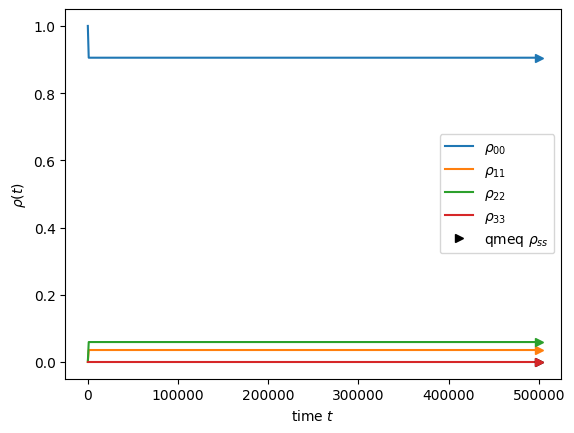

In [11]:
plt.plot(ti_array, np.real(rho_t[0]), label = r'$\rho_{00}$')
plt.plot(ti_array[-1],sys.phi0[0], '>',color = 'C0')

plt.plot(ti_array, np.real(rho_t[1]), label = r'$\rho_{11}$')
plt.plot(ti_array[-1],sys.phi0[1], '>',color = 'C1')


plt.plot(ti_array, np.real(rho_t[2]), label = r'$\rho_{22}$')
plt.plot(ti_array[-1],sys.phi0[2], '>',color = 'C2')



plt.plot(ti_array, np.real(rho_t[3]), label = r'$\rho_{33}$')
plt.plot(ti_array[-1],sys.phi0[3], '>',color = 'black', label = r'qmeq $\rho_{ss}$')
plt.plot(ti_array[-1],sys.phi0[3], '>',color = 'C3')

plt.legend()

plt.xlabel(r'time $t$')
plt.ylabel(r'$\rho(t)$')

Text(0, 0.5, '$\\rho(t)$')

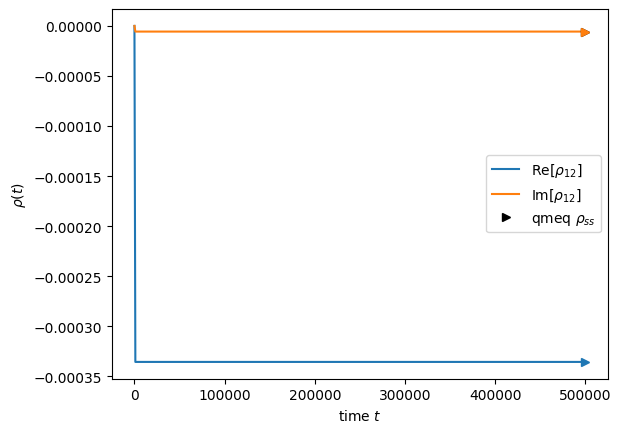

In [12]:
plt.plot(ti_array, np.real(rho_t[4]), label = r'Re[$\rho_{12}$]')
plt.plot(ti_array[-1],sys.phi0[4], '>',color = 'C0')



plt.plot(ti_array, np.real(rho_t[5]), label = r'Im[$\rho_{12}$]')
plt.plot(ti_array[-1],sys.phi0[5], '>',color = 'black', label = r'qmeq $\rho_{ss}$')
plt.plot(ti_array[-1],sys.phi0[5], '>',color = 'C1')

plt.legend()

plt.xlabel(r'time $t$')
plt.ylabel(r'$\rho(t)$')

In [13]:
# transient current

# qmeq solution for stationary current 
I_ss = sys.current

I_t_qmeq = np.zeros((nleads,ti_array.shape[0]))
I_t_CF = np.zeros((ti_array.shape[0]))


for i in range(ti_array.shape[0]):
    
    # reset current    
    sys.current[:] = np.zeros(nleads)
    
    # set stationary state to rho_t value
    sys.phi0[:] = np.real(rho_t[:,i])
    
    # calculate current (also calculates energy and heat currents)
    sys.appr.generate_current() # calculates current both ways
    I_t_qmeq[:,i] = sys.current
    I_t_CF[i] = sys.current_noise[0] 
    
    #--------------------------------------------
    
# combine contributions from left and right lead    
IL_t_qmeq = I_t_qmeq[0]
IR_t_qmeq = I_t_qmeq[1]

Text(0, 0.5, '$I(t)$')

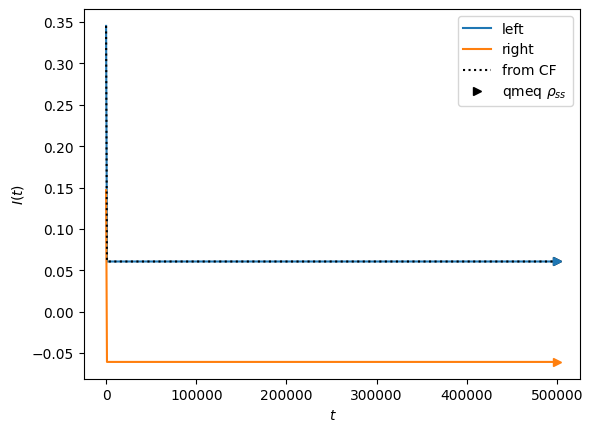

In [14]:
plt.plot(ti_array,IL_t_qmeq , label = 'left')
plt.plot(ti_array, IR_t_qmeq ,label = 'right')
plt.plot(ti_array[-1], (I_ss[1]), '>', color = 'C1' , )

plt.plot(ti_array, I_t_CF, ':', color = 'black', label = r'from CF')

plt.plot(ti_array[-1], I_ss[0],'>',color = 'black', label = r'qmeq $\rho_{ss}$')
plt.plot(ti_array[-1], I_ss[0], '>', color = 'C0', )

plt.legend()

plt.xlabel(r' $t$')
plt.ylabel(r'$I(t)$')